TODO: 
* Write a proper description
* Create 00- part for hypergraph creation

# Vectorizers on Hypergraphs

Unlike the recipe notebook, here we wish to classify the vertices *not* the hyperedges. In order to do so, we want to work on the dual. So first, we want to 

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# from src import paths
# from src.data import Dataset
# from src.user.viz import topic_word_by_class, topic_word_by_cluster

In [158]:
import hdbscan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.feature_extraction.text
import sklearn.preprocessing
import scipy.sparse
import vectorizers
import vectorizers.transformers
import umap
import umap.plot
import pynndescent
import seaborn as sns
import matplotlib.colors
import warnings
from bokeh.plotting import show
from sklearn.metrics import adjusted_rand_score

umap.plot.output_notebook()
warnings.simplefilter("ignore")
sns.set()


Loading BokehJS ...

## Vectorizing ABCD artificially generated hypergraphs

* https://arxiv.org/pdf/2210.15009.pdf

In [4]:
# This example is the first one suggested in the README file of the package
file_vertex_labels = '../data/h-ABCD/result_50_assign.txt'
file_hyperedges = '../data/h-ABCD/result_50_he.txt'

In [5]:
with open(file_hyperedges, 'r') as file:
    # Read all the lines of the file into a list
    lines = file.readlines()
hyperedges = [[int(y) for y in x.replace('\n','').split(',')] for x in lines]

In [6]:
with open(file_vertex_labels, 'r') as file:
    # Read all the lines of the file into a list
    vertex_labels = np.array([int(y) for y in file.read().splitlines()])

In [7]:
len(vertex_labels)

10000

In [8]:
max(vertex_labels)

14

In [9]:
# execfile('./00-recipes-setup.py')
# recipes, recipes_label_id, ingredients_id, label_name, color_key = read_format_recipes()

In [10]:
len(hyperedges)

21680

In [111]:
def TokenSetCooccurrenceVectorizer(hyperedges):
    long_list = max(len(x) for x in hyperedges)
    vertex_vectorizer_before = vectorizers.TokenCooccurrenceVectorizer(
        min_document_occurrences=1,
        window_radii=long_list,          
        window_functions='fixed',
        kernel_functions='flat',            
        n_iter = 0,
        window_orientations='before',
        normalize_windows=True,
    ).fit(hyperedges)

    vertex_vectorizer_after = vectorizers.TokenCooccurrenceVectorizer(
        min_document_occurrences=1,
        window_radii=long_list,          
        window_functions='fixed',
        kernel_functions='flat',            
        n_iter = 0,
        window_orientations='after',
        normalize_windows=True,
    ).fit(hyperedges)
    
    vertex_vectorizer_all = vertex_vectorizer_after
    vertex_vectorizer_all.cooccurrences_ = vertex_vectorizer_before.cooccurrences_ + vertex_vectorizer_after.cooccurrences_
    return(vertex_vectorizer_all)

# Vectorize vertices

In [89]:
%%time
long_list = max(len(x) for x in hyperedges)
vertex_vectorizer = vectorizers.TokenCooccurrenceVectorizer(
    min_document_occurrences=1,
    window_radii=long_list,          
    window_functions='fixed',
    kernel_functions='flat',            
    n_iter = 0,
    normalize_windows=True,
).fit(hyperedges)
vertex_vectors = vertex_vectorizer.reduce_dimension(dimension=60, algorithm="randomized")

CPU times: user 2.61 s, sys: 376 ms, total: 2.99 s
Wall time: 1.33 s


In [101]:
vertex_vectorizer.cooccurrences_.sum(axis=1)

matrix([[100.       ],
        [ 99.       ],
        [ 99.00001  ],
        ...,
        [  5.       ],
        [  5.       ],
        [  4.9999995]], dtype=float32)

In [112]:
%%time
vertex_vectorizer = TokenSetCooccurrenceVectorizer(hyperedges)
vertex_vectors = vertex_vectorizer_all.reduce_dimension(dimension=60, algorithm="randomized")

CPU times: user 2.2 s, sys: 237 ms, total: 2.44 s
Wall time: 1.64 s


In [113]:
%%time
vertex_mapper = umap.UMAP(n_neighbors=8, metric = 'cosine', random_state=42).fit(vertex_vectors)

CPU times: user 32.5 s, sys: 10 s, total: 42.5 s
Wall time: 8.71 s


In [114]:
hdbscan_labels = hdbscan.HDBSCAN(min_cluster_size=30).fit_predict(vertex_mapper.embedding_)

In [115]:
from collections import Counter
Counter(hdbscan_labels)

Counter({2: 632,
         13: 915,
         12: 697,
         4: 497,
         7: 710,
         6: 507,
         3: 858,
         5: 805,
         8: 724,
         1: 532,
         10: 879,
         9: 559,
         0: 532,
         11: 701,
         -1: 452})

In [116]:
hdbscan_labels!=-1

array([ True,  True,  True, ...,  True,  True,  True])

In [117]:
adjusted_rand_score(hdbscan_labels[hdbscan_labels!=-1], vertex_labels[hdbscan_labels!=-1])

0.7025487838217824

In [118]:
hover_data=pd.DataFrame()
hover_data['vocab'] = [vertex_vectorizer.token_index_dictionary_[x] 
                       for x in range(len(vertex_vectorizer.token_index_dictionary_))]

p = umap.plot.interactive(
    vertex_mapper, 
    hover_data=hover_data, 
    # labels=vertex_labels,
    point_size=5, 
    values=np.log(vertex_vectorizer._token_frequencies_), 
    interactive_text_search=True, 
    interactive_text_search_alpha_contrast=0.99)
show(p)

# Hyperedge as vocabulary

We start by embedding hyperedges as vocabulary elements. The vertices will then be considered as a *bag of hyperedges* they are part of.

In [119]:
n = len(vertex_labels)
n

10000

In [120]:
# Get the dual hypergraph as a list of lists
vertex_dict = dict()
for i in range(1, n+1):
    vertex_dict[i] = []
for i, he in enumerate(hyperedges):
    for v in he:
        vertex_dict[v].append(i)

In [121]:
# The dual has one list per vertex
dual_hyperedges = [vertex_dict[i] for i in range(1, n+1)]

In [122]:
len(dual_hyperedges)

10000

In [136]:
%%time
element_vectorizer = TokenSetCooccurrenceVectorizer(dual_hyperedges)
element_vectors = he_vectorizer.reduce_dimension(dimension=60, algorithm="randomized")

CPU times: user 8.66 s, sys: 1.64 s, total: 10.3 s
Wall time: 4.94 s


In [124]:
# %%time
# long_list = max(len(x) for x in dual_hyperedges)
# he_vectorizer = vectorizers.TokenCooccurrenceVectorizer(
#     min_document_occurrences=1,
#     window_radii=long_list,          
#     window_functions='fixed',
#     kernel_functions='flat',            
#     n_iter = 0,
#     normalize_windows=True,
# ).fit(dual_hyperedges)
# he_vectors = he_vectorizer.reduce_dimension(dimension=60, algorithm="randomized")

In [137]:
element_vectors.shape

(21680, 60)

----
## Vertex Embedding

There are 3 steps to obtain the Approximate Wasserstein recipe embedding: 
1. **Vertex(bag-of-hyperedge) Embedding** via `NgramVectorizer`: This step uses a bag-of-words approach to vectorize documents. 
2. **Information Weight Embedding** via `InformationWeightTransformer`: This step takes an information theoretic view to generating feature weights for count data (inspired by TF-IDF). 
3. **Approximate Wasserstein Embedding (AWE)** via `ApproximateWassersteinVectorizer`: This step takes into account the fact that our ingredients are not independent of each other and have similarities (interchangeability) should be treated as distributions in their own right. This is a linear algebra approximation to the Wasserstein Embedding (WE) (aka. the fast way to do WE).


In [132]:
%%time
incidence_vectors = vectorizers.NgramVectorizer(
    token_dictionary=he_vectorizer.token_label_dictionary_
).fit_transform(dual_hyperedges)

CPU times: user 368 ms, sys: 0 ns, total: 368 ms
Wall time: 368 ms


In [133]:
incidence_vectors.shape

(10000, 21680)

In [135]:
%%time
incidence_mapper = umap.UMAP(metric="hellinger", random_state=42).fit(incidence_vectors)

CPU times: user 3min 51s, sys: 4.69 s, total: 3min 56s
Wall time: 1min 41s


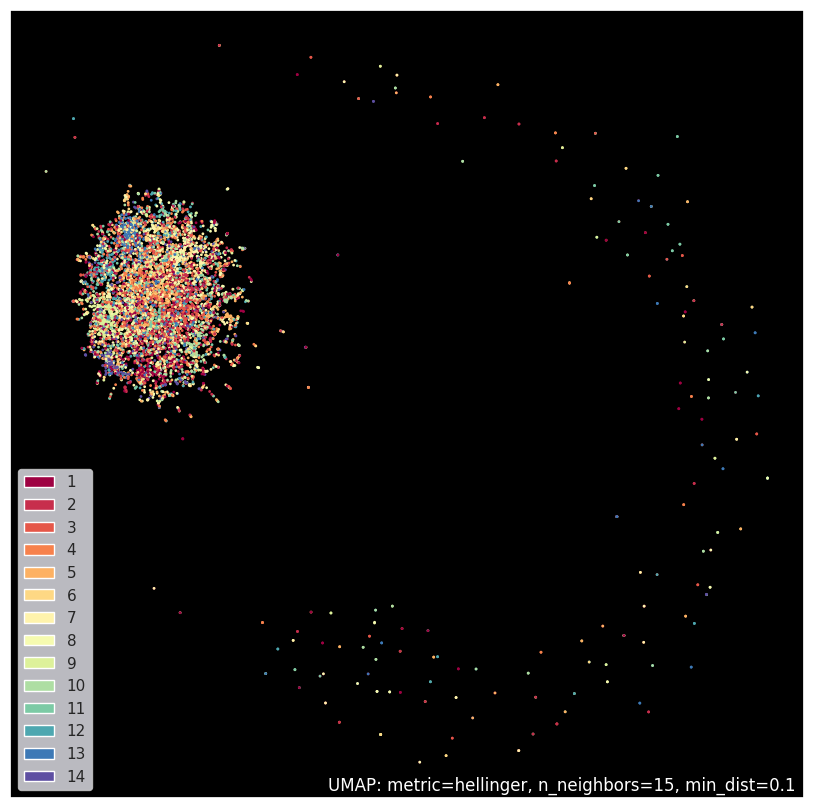

In [138]:
import matplotlib._color_data as mcd
palette = list(mcd.XKCD_COLORS.values())[::20]

umap.plot.points(
    incidence_mapper,
    labels=np.array(vertex_labels),
    background="black",
    width=1024,
    height=1024,
);

In [139]:
%%time
info_transformer = vectorizers.transformers.InformationWeightTransformer(
    prior_strength=1e-1,
    approx_prior=False,
)
info_incidence_vectors = info_transformer.fit_transform(incidence_vectors)

CPU times: user 8.5 s, sys: 257 ms, total: 8.75 s
Wall time: 602 ms


In [140]:
%%time
info_incidence_mapper = umap.UMAP(metric="cosine", random_state=42).fit(info_incidence_vectors)

CPU times: user 2min 15s, sys: 3.88 s, total: 2min 19s
Wall time: 18.3 s


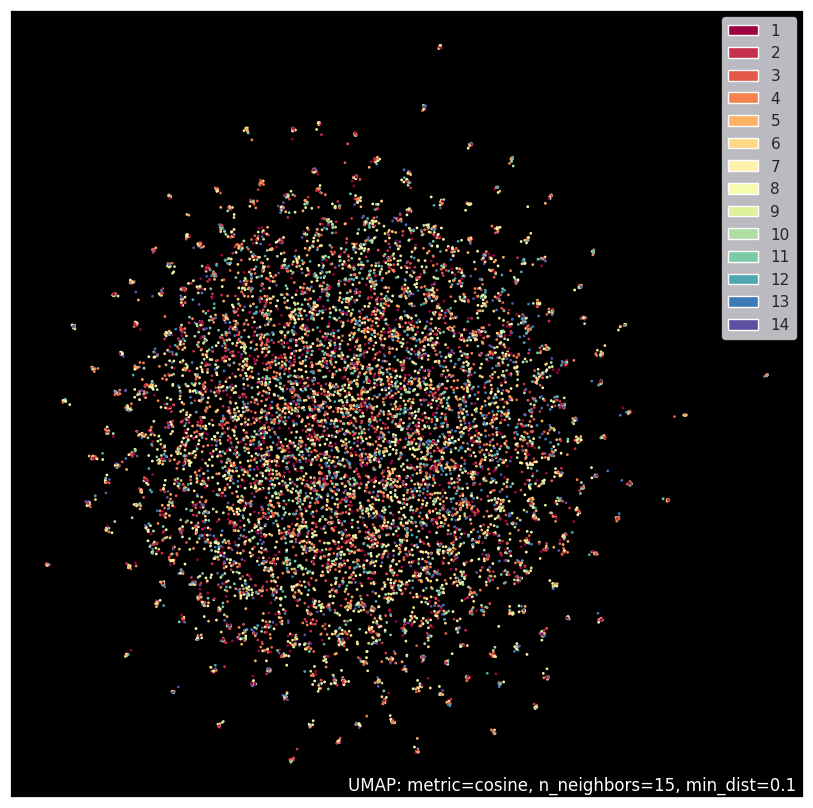

In [141]:
import matplotlib._color_data as mcd
palette = list(mcd.XKCD_COLORS.values())[::20]

p = umap.plot.points(
    info_incidence_mapper,
    labels=np.array(vertex_labels),
    background="black",
    width=1024,
    height=1024,
);

In [160]:
element_vectors.shape

(21680, 60)

In [162]:
info_incidence_vectors.data

array([0.78928018, 0.92112647, 0.76096199, ..., 0.8139257 , 1.15317167,
       0.90095954])

In [142]:
%%time
awe_vertex_vectorizer = vectorizers.ApproximateWassersteinVectorizer(
    normalization_power=0.66,
    random_state=42,
)
awe_vectors = awe_vertex_vectorizer.fit_transform(info_incidence_vectors, vectors=element_vectors)

CPU times: user 1.25 s, sys: 43.9 ms, total: 1.3 s
Wall time: 48.4 ms


In [164]:
awe_vectors.shape

(10000, 60)

In [143]:
%%time
awe_mapper = umap.UMAP(metric="cosine", random_state=42).fit(awe_vectors)

CPU times: user 43.4 s, sys: 15.5 s, total: 58.9 s
Wall time: 12.9 s


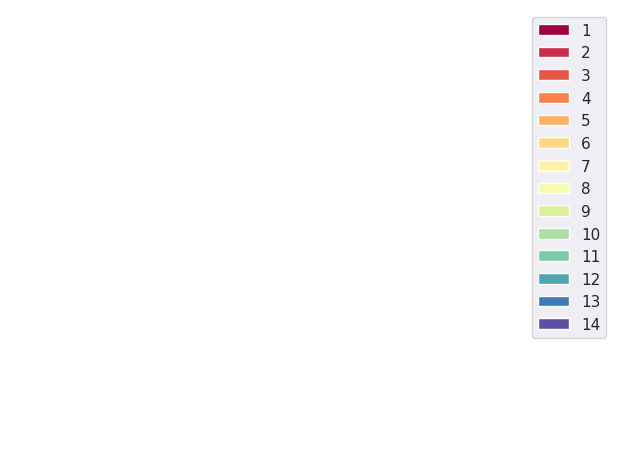

In [144]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1) #create the axes
ax.set_axis_off() #turn off the axis
legend_label = [w.get_text() for w in list(p.legend_.get_texts())]
ax.legend(handles = p.legend_.legendHandles, labels = legend_label) #legend alone in the figure
fig.tight_layout()
plt.show()

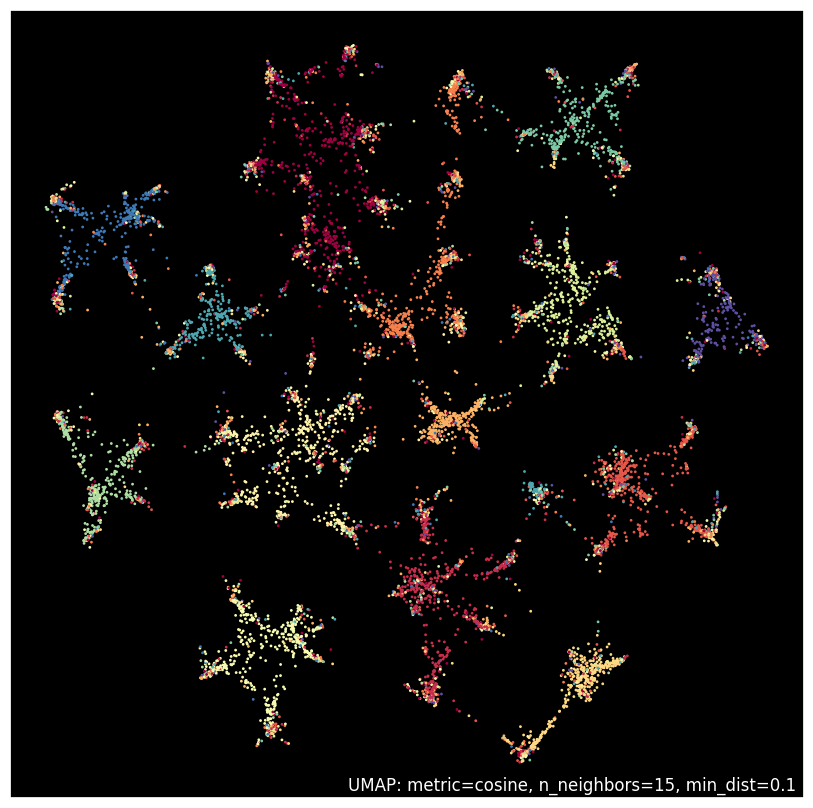

In [145]:
p = umap.plot.points(
    awe_mapper,
    labels=np.array(vertex_labels),
    background="black",
    width=1024,
    height=1024,
    show_legend=False
);

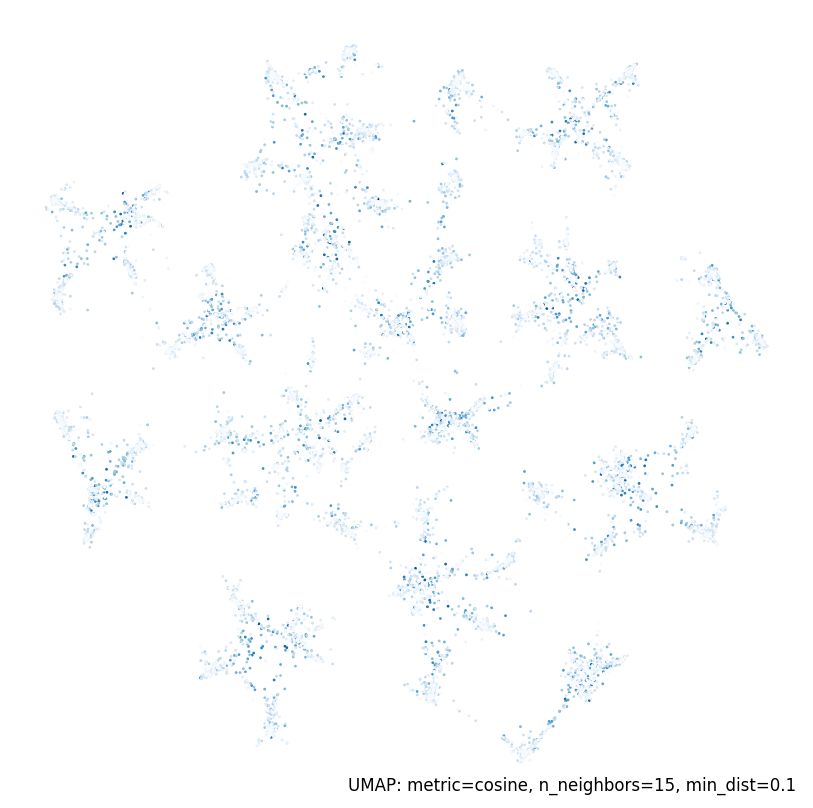

In [146]:
p = umap.plot.points(
    awe_mapper, 
    values=np.log(vertex_vectorizer._token_frequencies_),
    background="white",
    width=1024,
    height=1024,
    show_legend=False
);

In [165]:
hdbscan_labels_awe = hdbscan.HDBSCAN(min_cluster_size=30).fit_predict(awe_mapper.embedding_)
adjusted_rand_score(hdbscan_labels[hdbscan_labels!=-1], vertex_labels[hdbscan_labels!=-1])

0.7025487838217824

In [166]:
sum(hdbscan_labels!=-1)

9548

In [35]:
p = umap.plot.interactive(
    awe_mapper, 
    # hover_data=hover_data, 
    # labels=vertex_labels,
    point_size=5, 
    values=np.log(vertex_vectorizer._token_frequencies_), 
    interactive_text_search=True, 
    interactive_text_search_alpha_contrast=0.99)
show(p)

In [ ]:
import matplotlib._color_data as mcd
palette = list(mcd.XKCD_COLORS.values())[::20]

p = umap.plot.points(
    awe_vertex_mapper,
    labels=np.array(vertex_labels),
    background="black",
    width=1024,
    height=1024,
);
p.legend(loc='upper left')

# Downstream task

In [149]:
import sklearn.model_selection
import sklearn.ensemble
import sklearn.linear_model
import sklearn.neural_network
import sklearn.neighbors

from sklearn.experimental import enable_hist_gradient_boosting

In [151]:
cooc_16 = sklearn.decomposition.TruncatedSVD(n_components=16, n_iter=20).fit_transform(vertex_vectors)
bow_16 = sklearn.decomposition.TruncatedSVD(n_components=16, n_iter=20).fit_transform(incidence_vectors)
info_16 = sklearn.decomposition.TruncatedSVD(n_components=16, n_iter=20).fit_transform(info_incidence_vectors)
# awe_16 = sklearn.decomposition.TruncatedSVD(n_components=16, n_iter=20).fit_transform(awe_vectors)

In [152]:
def cross_validate(model, data, recipes_label, n_splits=20, test_ratio=0.1, random_seed=42):
    splitter = sklearn.model_selection.ShuffleSplit(
        n_splits=n_splits, test_size=test_ratio, random_state=random_seed
    )
    result = sklearn.model_selection.cross_val_score(model, data, recipes_label, cv=splitter)
    return result

def cross_validation_dataframe(model, feature_sets, recipes_label, n_splits=20, test_ratio=0.1, random_seed=42):
    dfs = []
    for feature_space_name, feature_space in feature_sets.items():
        cv_scores = cross_validate(model, feature_space, recipes_label, n_splits, test_ratio, random_seed)
        feature_df = pd.DataFrame(
            {
                "run" : np.arange(n_splits), 
                "Embedding" : feature_space_name,
                "Model" : model.__repr__().split("(")[0],
                "Accuracy" : cv_scores
            }
        )
        dfs.append(feature_df)
    return pd.concat(dfs)

In [153]:
models = [
    sklearn.neighbors.KNeighborsClassifier(metric="cosine", n_neighbors=5, weights="distance"),
    # sklearn.ensemble.HistGradientBoostingClassifier(),
    sklearn.ensemble.RandomForestClassifier(),
    # sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(20, 10, 15))
]
feature_sets = {
    "Co-occurences": cooc_16,
    "Counts": bow_16,
    "InfoWeighted": info_16,
    "A-Wasserstein": awe_vectors,
    # "Supervised-A-Wasserstein": lat_vectors_supervised,
}

In [154]:
%%time
results = []
for model in models:
    print(model)
    res = cross_validation_dataframe(
        model, 
        feature_sets,
        vertex_labels,
    )
    results.append(res)

df_all = pd.concat( results )

KNeighborsClassifier(metric='cosine', weights='distance')
RandomForestClassifier()
CPU times: user 10min 16s, sys: 19 s, total: 10min 35s
Wall time: 5min 26s


In [155]:
df = df_all

In [156]:
# pourquoi toutes les accuracies sont des multiples de 10? Parce qu'on ne testait que 10 points (sur 100).
# pourquoi il n'y a pas de résultat de MLP pour Wasserstein?

In [157]:
# df[df.Embedding=='InfoWeighted']

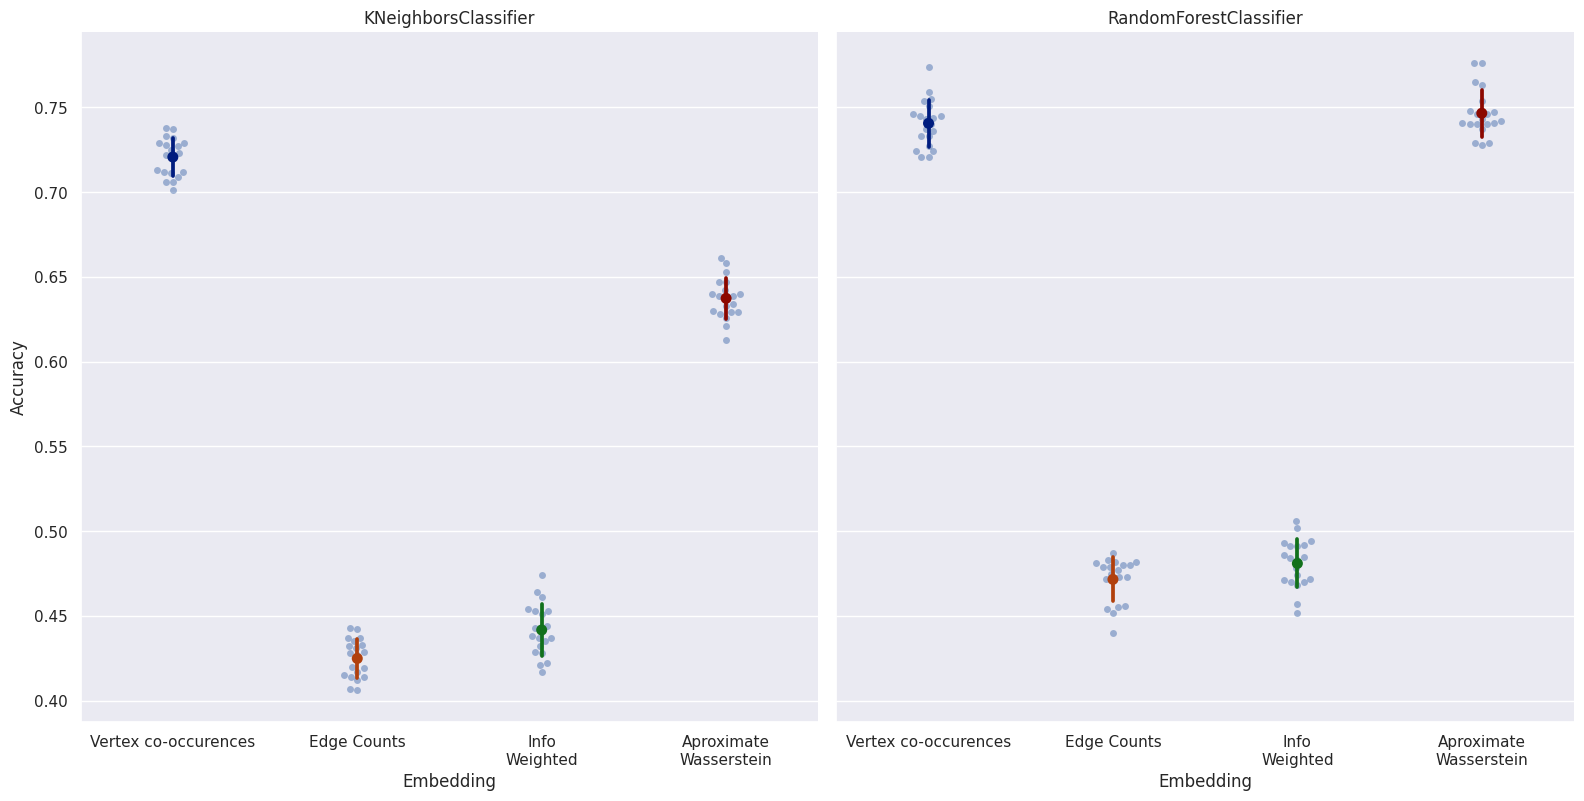

In [48]:
g = sns.catplot(
    kind="swarm", 
    x="Embedding", 
    y="Accuracy", 
    col="Model",
    col_wrap=2,
    # data=df[df.Accuracy >= 0.5],
    data = df,
    height=8, 
    alpha=0.5,
    zorder=1,
)
g.map_dataframe(
    sns.pointplot, 
    x="Embedding", 
    y="Accuracy", 
    color="Model", 
    data = df,
    # data=df[df.Accuracy >= 0.5], 
    # height=6, 
    # aspect=1.3,
    palette="dark",
    join=False,
    order=[
        "Co-occurences",
        "Counts", 
        "InfoWeighted", 
        "A-Wasserstein"
    ],
    ci="sd",
    # zorder=2,
    scale=0.9,
)
g.set_titles(col_template="{col_name}")
g.set_xticklabels([
    "Vertex co-occurences",
    "Incidence Matrix", 
    "Info\nWeighted Incidence", 
    "Aproximate\nWasserstein"
])
# g.savefig("figures/recipe_embedding_comparison_downstream_task.png", facecolor="none")